<h3>輸入原影像，經過壓縮轉換，再由轉換壓縮碼，還原成類原圖</h3>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
from glob import glob
import numpy

In [3]:
import cv2

In [4]:
import tensorflow

In [5]:
import keras

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib import cm

<h3>環境設置</h3>

In [7]:
image_path = 'images/objects/train'
max_dim = (256, 256, 3)
enhance_flag = False

kernel = numpy.array([[-1, -1, -1], [-1, 11, -1], [-1, -1, -1]])

alpha = 0.6 # Contrast control (1.0-3.0)
beta = 2 # Brightness control (0-100)

<h3>載入魚影像檔</h3>

In [8]:
def read_image_file(my_image_file, enhanced=False):
    global max_dim, kernel, alpha, beta
    
    _fish_image = cv2.imread(my_image_file, cv2.COLOR_BGR2RGB)
    
    if enhanced:
        _fish_image = cv2.filter2D(_fish_image, -1, kernel)
        _fish_image = cv2.convertScaleAbs(_fish_image.copy(), alpha=alpha, beta=beta)

    _fish_image = cv2.resize(_fish_image.copy(), max_dim[:2])
    
    return _fish_image

In [9]:
def show_image(my_image):
    fig, ax = plt.subplots(dpi=120)
    ax.imshow(my_image)
    ax.axis('off')
    plt.show()

<h3>載入魚影像檔</h3>

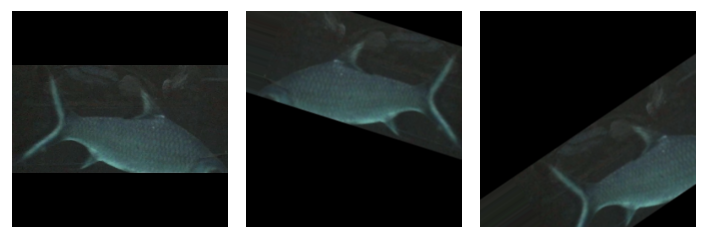

In [10]:
datagen = ImageDataGenerator(rotation_range=45,
                             width_shift_range=[0.1, 0.2],
                             height_shift_range=[0.1, 0.2],
                             horizontal_flip=True)

_fish_image = read_image_file('%s/F000079-00001.jpg' % image_path, enhance_flag)

fig, ax = plt.subplots(dpi=120, ncols=3)

ax[0].imshow(_fish_image)
ax[0].axis('off')

_fish_img_data = img_to_array(_fish_image)    
_fish_img_data = numpy.expand_dims(_fish_img_data, 0)

it = datagen.flow(_fish_img_data, batch_size=1)

for i in range(1, 3):
    _batch = it.next()
    _generated_image = _batch[0].astype('uint8')
            
    ax[i].imshow(_generated_image, cmap='gray', interpolation='bicubic')
    ax[i].axis('off')
    
plt.tight_layout()
plt.show()

In [11]:
def load_data(image_path, train_ratio=0.8, enhanced=False):
    global max_dim

    datagen = ImageDataGenerator(rotation_range=45,
                                 width_shift_range=[0.1, 0.2],
                                 height_shift_range=[0.1, 0.2],
                                 horizontal_flip=True
    )
    
    image_files = glob('%s/F*.jpg' % image_path)

    my_images = []

    for image_file in image_files:
        _image_file = image_file.replace('\\', '/')
        
        _fish_image = read_image_file(_image_file, enhanced)
        
        my_images.append(numpy.reshape(_fish_image, max_dim))

        _fish_img_data = img_to_array(_fish_image)    
        _fish_img_data = numpy.expand_dims(_fish_img_data, 0)
        
        it = datagen.flow(_fish_img_data, batch_size=1)

        for i in range(10):
            _batch = it.next()
            _generated_image = _batch[0].astype('uint8')
            
            my_images.append(numpy.reshape(_generated_image, max_dim))

    my_images = numpy.array(my_images)
    numpy.random.shuffle(my_images)
    
    pos = int(my_images.shape[0] * train_ratio)
    return my_images[:pos], my_images[pos:]

In [13]:
x_train, x_test = load_data(image_path='images/objects/train', train_ratio=0.8, enhanced=enhance_flag)

In [14]:
x_train.shape, x_test.shape

((4488, 256, 256, 3), (1122, 256, 256, 3))

<h3>將 0 ~ 255 值域，轉換為: 0 ~ 1</h3>

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

<h3>轉換 256x256 二維度為 65536 一維度</h3>

In [16]:
x_train = x_train.reshape((x_train.shape[0], numpy.prod(x_train.shape[1:])))
x_test = x_test.reshape((x_test.shape[0], numpy.prod(x_test.shape[1:])))

In [17]:
x_train.shape, x_test.shape

((4488, 196608), (1122, 196608))

<h3>參數設置</h3>
<p>$$壓縮率: \frac {65536}{64} = 1024$$</p>

In [75]:
encode_dimension = 8
encoding_dim = encode_dimension * encode_dimension

num_of_epoch = 512
num_of_batch_size = 8

<h3>建立模型</h3>

In [76]:
input_img = keras.Input(shape=(x_train.shape[1],), name='input')

In [77]:
encoded_256 = layers.Dense(256, name='encoded_256', activation='relu')(input_img)
encoded_128 = layers.Dense(128, name='encoded_128', activation='relu')(encoded_256)
encoded = layers.Dense(encoding_dim, name='latent', activation='relu')(encoded_128)

In [78]:
decoded_128 = layers.Dense(128, name='decoded_128', activation='relu')(encoded)
decoded_256 = layers.Dense(256, name='decoded_256', activation='relu')(decoded_128)
decoded = layers.Dense(x_train.shape[1], name='output', activation='sigmoid')(decoded_256)

In [79]:
autoencoder = keras.Model(input_img, decoded, name='autoencoder')

In [80]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 196608)]          0         
_________________________________________________________________
encoded_256 (Dense)          (None, 256)               50331904  
_________________________________________________________________
encoded_128 (Dense)          (None, 128)               32896     
_________________________________________________________________
latent (Dense)               (None, 64)                8256      
_________________________________________________________________
decoded_128 (Dense)          (None, 128)               8320      
_________________________________________________________________
decoded_256 (Dense)          (None, 256)               33024     
_________________________________________________________________
output (Dense)               (None, 196608)            

In [81]:
encoder = keras.Model(input_img, encoded)
encoded_input = keras.Input(shape=(encoding_dim,))

In [82]:
decoder_layer_128 = autoencoder.layers[-3]
decoder_layer_256 = autoencoder.layers[-2]
decoder_layer = autoencoder.layers[-1]

decoder = keras.Model(encoded_input, 
                      decoder_layer(decoder_layer_256(
                          decoder_layer_128(encoded_input))))

In [83]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

<h3>訓練模型</h3>

In [84]:
checkpointer = ModelCheckpoint(
    filepath='NLP-C-0-256-128.hdf5', 
    monitor="val_loss", verbose=1, 
    save_best_only=True, mode='auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=50)

In [85]:
score = autoencoder.fit(x_train, x_train,
                        epochs=num_of_epoch,
                        batch_size=num_of_batch_size,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        callbacks=[checkpointer, earlyStop]
                       )

Epoch 1/512
561/561 [==============================] - ETA: 0s - loss: 0.3105
Epoch 00001: val_loss improved from inf to 0.29567, saving model to NLP-C-0-256-128.hdf5
561/561 [==============================] - 17s 31ms/step - loss: 0.3105 - val_loss: 0.2957
Epoch 2/512
561/561 [==============================] - ETA: 0s - loss: 0.2875
Epoch 00002: val_loss improved from 0.29567 to 0.28730, saving model to NLP-C-0-256-128.hdf5
561/561 [==============================] - 16s 28ms/step - loss: 0.2875 - val_loss: 0.2873
Epoch 3/512
561/561 [==============================] - ETA: 0s - loss: 0.2823
Epoch 00003: val_loss improved from 0.28730 to 0.28259, saving model to NLP-C-0-256-128.hdf5
561/561 [==============================] - 16s 28ms/step - loss: 0.2823 - val_loss: 0.2826
Epoch 4/512
561/561 [==============================] - ETA: 0s - loss: 0.2791
Epoch 00004: val_loss improved from 0.28259 to 0.27988, saving model to NLP-C-0-256-128.hdf5
561/561 [==============================] - 16s 

Epoch 34/512
561/561 [==============================] - ETA: 0s - loss: 0.2663
Epoch 00034: val_loss did not improve from 0.26979
561/561 [==============================] - 8s 15ms/step - loss: 0.2663 - val_loss: 0.2703
Epoch 35/512
561/561 [==============================] - ETA: 0s - loss: 0.2663
Epoch 00035: val_loss did not improve from 0.26979
561/561 [==============================] - 8s 15ms/step - loss: 0.2663 - val_loss: 0.2699
Epoch 36/512
561/561 [==============================] - ETA: 0s - loss: 0.2662
Epoch 00036: val_loss did not improve from 0.26979
561/561 [==============================] - 8s 15ms/step - loss: 0.2662 - val_loss: 0.2702
Epoch 37/512
561/561 [==============================] - ETA: 0s - loss: 0.2660
Epoch 00037: val_loss did not improve from 0.26979
561/561 [==============================] - 8s 15ms/step - loss: 0.2660 - val_loss: 0.2699
Epoch 38/512
561/561 [==============================] - ETA: 0s - loss: 0.2660
Epoch 00038: val_loss improved from 0.269

561/561 [==============================] - ETA: 0s - loss: 0.2649
Epoch 00070: val_loss did not improve from 0.26891
561/561 [==============================] - 8s 15ms/step - loss: 0.2649 - val_loss: 0.2691
Epoch 71/512
561/561 [==============================] - ETA: 0s - loss: 0.2648
Epoch 00071: val_loss did not improve from 0.26891
561/561 [==============================] - 8s 15ms/step - loss: 0.2648 - val_loss: 0.2694
Epoch 72/512
561/561 [==============================] - ETA: 0s - loss: 0.2650
Epoch 00072: val_loss did not improve from 0.26891
561/561 [==============================] - 8s 15ms/step - loss: 0.2650 - val_loss: 0.2692
Epoch 73/512
561/561 [==============================] - ETA: 0s - loss: 0.2649
Epoch 00073: val_loss did not improve from 0.26891
561/561 [==============================] - 8s 15ms/step - loss: 0.2649 - val_loss: 0.2697
Epoch 74/512
561/561 [==============================] - ETA: 0s - loss: 0.2649
Epoch 00074: val_loss did not improve from 0.26891
561

Epoch 107/512
561/561 [==============================] - ETA: 0s - loss: 0.2644
Epoch 00107: val_loss did not improve from 0.26866
561/561 [==============================] - 8s 15ms/step - loss: 0.2644 - val_loss: 0.2692
Epoch 108/512
561/561 [==============================] - ETA: 0s - loss: 0.2645
Epoch 00108: val_loss did not improve from 0.26866
561/561 [==============================] - 8s 15ms/step - loss: 0.2645 - val_loss: 0.2689
Epoch 109/512
561/561 [==============================] - ETA: 0s - loss: 0.2644
Epoch 00109: val_loss did not improve from 0.26866
561/561 [==============================] - 8s 15ms/step - loss: 0.2644 - val_loss: 0.2692
Epoch 110/512
561/561 [==============================] - ETA: 0s - loss: 0.2645
Epoch 00110: val_loss did not improve from 0.26866
561/561 [==============================] - 8s 15ms/step - loss: 0.2645 - val_loss: 0.2695
Epoch 111/512
561/561 [==============================] - ETA: 0s - loss: 0.2645
Epoch 00111: val_loss did not improv

561/561 [==============================] - ETA: 0s - loss: 0.2639
Epoch 00144: val_loss did not improve from 0.26866
561/561 [==============================] - 8s 15ms/step - loss: 0.2639 - val_loss: 0.2689
Epoch 145/512
561/561 [==============================] - ETA: 0s - loss: 0.2644
Epoch 00145: val_loss did not improve from 0.26866
561/561 [==============================] - 8s 15ms/step - loss: 0.2644 - val_loss: 0.2690
Epoch 146/512
561/561 [==============================] - ETA: 0s - loss: 0.2643
Epoch 00146: val_loss did not improve from 0.26866
561/561 [==============================] - 8s 15ms/step - loss: 0.2643 - val_loss: 0.2693
Epoch 147/512
561/561 [==============================] - ETA: 0s - loss: 0.2644
Epoch 00147: val_loss did not improve from 0.26866
561/561 [==============================] - 8s 15ms/step - loss: 0.2644 - val_loss: 0.2692
Epoch 148/512
561/561 [==============================] - ETA: 0s - loss: 0.2641
Epoch 00148: val_loss did not improve from 0.26866

<h3>模型訓練績效</h3>

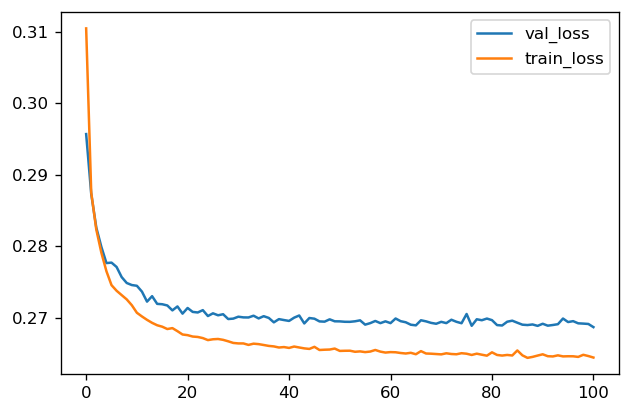

In [86]:
best_iteration = numpy.argmin(score.history['val_loss']) + 1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

fig, ax = plt.subplots(dpi=120)

ax.plot(val_scores, label='val_loss')
ax.plot(train_scores, label='train_loss')

plt.legend(loc='upper right')
plt.show()

<h3>產生假圖</h3>

In [87]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [88]:
x_test.shape, encoded_imgs.shape, decoded_imgs.shape

((1122, 196608), (1122, 64), (1122, 196608))

<h3>隨機顯示抽象圖與假圖</h3>

In [89]:
i = numpy.random.randint(0, x_test.shape[0], 1)[0]

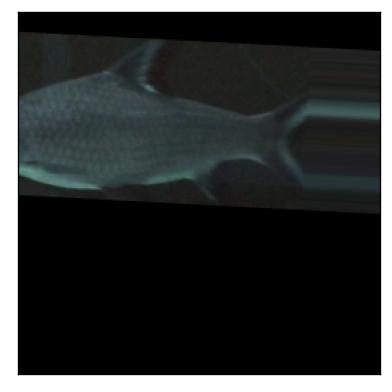

In [90]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(x_test[i].reshape(max_dim))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

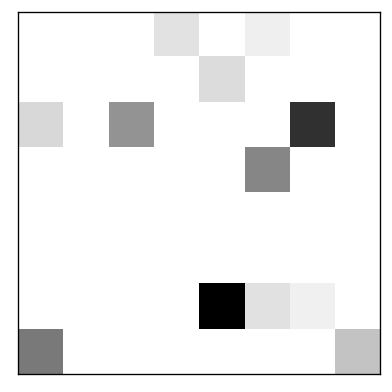

In [91]:
fig, ax = plt.subplots(dpi=120)

encode_dimension = int(encoding_dim**0.5)
encoded_imgs_min = encoded_imgs[i].min()
encoded_imgs_max = encoded_imgs[i].max()
encoded_imgs_val = (encoded_imgs[i] - encoded_imgs_min) / (encoded_imgs_max - encoded_imgs_min)

ax.imshow(encoded_imgs_val.reshape(encode_dimension, encode_dimension), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

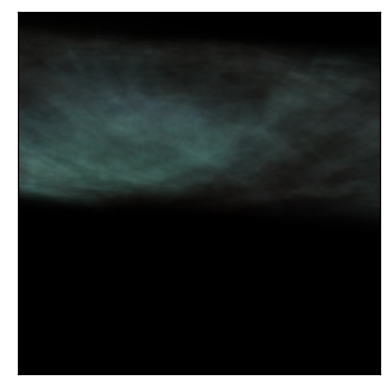

In [92]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

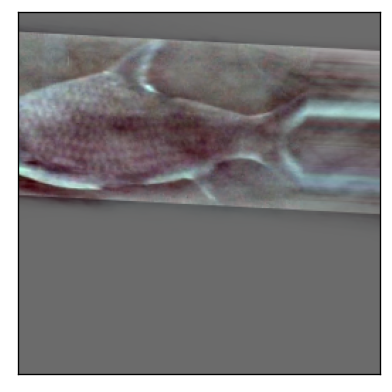

In [93]:
fig, ax = plt.subplots(dpi=120)

diff_image = x_test[i] - decoded_imgs[i]
diff_image_min = diff_image.min()
diff_image_max = diff_image.max()
diff_image_val = (diff_image - diff_image_min) / (diff_image_max - diff_image_min)

ax.imshow(diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

<h3>顯示原圖與假圖</h3>

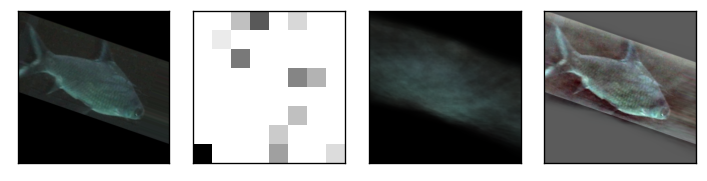

In [113]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(dpi=120, ncols=4)

ax0.imshow(x_test[i].reshape(max_dim), cmap=plt.cm.binary)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

encoded_imgs_min = encoded_imgs[i].min()
encoded_imgs_max = encoded_imgs[i].max()
encoded_imgs_val = (encoded_imgs[i] - encoded_imgs_min) / (encoded_imgs_max - encoded_imgs_min)

ax1.imshow(encoded_imgs_val.reshape(encode_dimension, encode_dimension), cmap=plt.cm.binary)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.imshow(decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

diff_image = x_test[i] - decoded_imgs[i]
diff_image_min = diff_image.min()
diff_image_max = diff_image.max()
diff_image_val = (diff_image - diff_image_min) / (diff_image_max - diff_image_min)

ax3.imshow(diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [119]:
def benchmark(my_diff_image):
    diff = 0.0
    
    for i in range(max_dim[2]):
        diff += numpy.sum(numpy.square(diff_image[i]))
        
    return diff**0.5

In [116]:
benchmark(diff_image.reshape(max_dim))

0.17790308741983718

<h3>隨機顯示抽象圖</h3>

In [97]:
faint_image_files = glob('%s/F*.jpg' % 'images/objects/faint')

my_faint_images = []

for image_file in faint_image_files[:24]:
    _image_file = image_file.replace('\\', '/')

    _fish_image = read_image_file(_image_file, enhance_flag)

    my_faint_images.append(numpy.reshape(_fish_image, max_dim))

my_faint_images = numpy.array(my_faint_images)

my_faint_images = my_faint_images.astype('float32') / 255.

_max_dim = max_dim[0] * max_dim[1] * max_dim[2]
my_faint_images = numpy.reshape(my_faint_images, (my_faint_images.shape[0], _max_dim))

my_faint_images.shape

(24, 196608)

In [98]:
faint_encoded_imgs = encoder.predict(my_faint_images)
faint_decoded_imgs = decoder.predict(faint_encoded_imgs)

In [99]:
def find_faint_file_pos(my_image_id=None):
    pos = -1
    
    if my_image_id is None:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
    else:
        for j in range(len(faint_image_files)):
            image_file = faint_image_files[j]
            if my_image_id in image_file:
                pos = j
                break
            
    if pos == -1:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
        
    return pos

In [100]:
i = find_faint_file_pos()

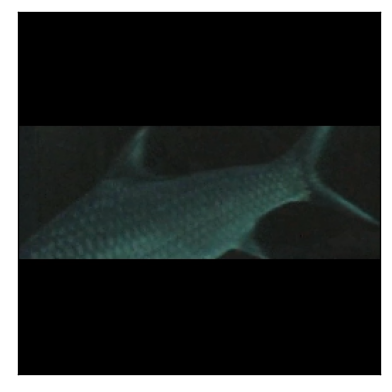

In [101]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(my_faint_images[i].reshape(max_dim))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

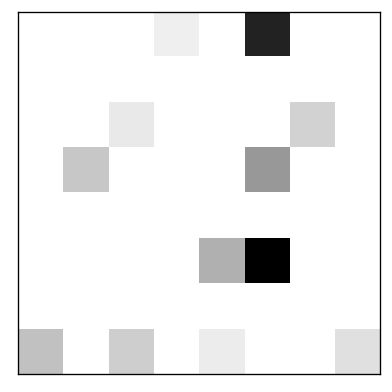

In [102]:
fig, ax = plt.subplots(dpi=120)

faint_encoded_imgs_min = faint_encoded_imgs[i].min()
faint_encoded_imgs_max = faint_encoded_imgs[i].max()
faint_encoded_imgs_val = (faint_encoded_imgs[i] - faint_encoded_imgs_min) / (faint_encoded_imgs_max - faint_encoded_imgs_min)

ax.imshow(faint_encoded_imgs_val.reshape(encode_dimension, encode_dimension), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

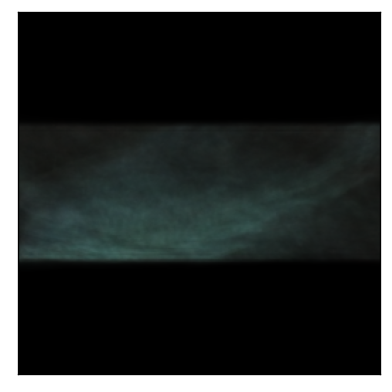

In [103]:
fig, ax = plt.subplots(dpi=120)

ax.imshow(faint_decoded_imgs[i].reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

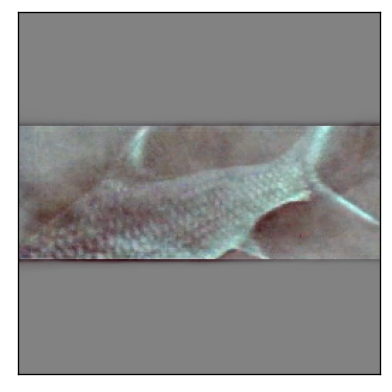

In [104]:
fig, ax = plt.subplots(dpi=120)

faint_diff_image = my_faint_images[i] - faint_decoded_imgs[i]
faint_diff_image_min = faint_diff_image.min()
faint_diff_image_max = faint_diff_image.max()
faint_diff_image_val = (faint_diff_image - faint_diff_image_min) / (faint_diff_image_max - faint_diff_image_min)

ax.imshow(faint_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [120]:
benchmark(faint_diff_image.reshape(max_dim))

0.17790308741983718

In [107]:
my_model = keras.models.load_model('NLP-C-0-256-128.hdf5')
print(my_model.summary())

faint_encoder = Model(inputs=my_model.input, outputs=my_model.get_layer('latent').output)

faint_encoded_imgs = faint_encoder.predict(my_faint_images)
faint_encoded_imgs = faint_encoded_imgs.reshape((len(faint_encoded_imgs), encode_dimension, encode_dimension, 1))

faint_decoded_imgs = my_model.predict(my_faint_images)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 196608)]          0         
_________________________________________________________________
encoded_256 (Dense)          (None, 256)               50331904  
_________________________________________________________________
encoded_128 (Dense)          (None, 128)               32896     
_________________________________________________________________
latent (Dense)               (None, 64)                8256      
_________________________________________________________________
decoded_128 (Dense)          (None, 128)               8320      
_________________________________________________________________
decoded_256 (Dense)          (None, 256)               33024     
_________________________________________________________________
output (Dense)               (None, 196608)            

<h3>顯示原圖與假圖</h3>

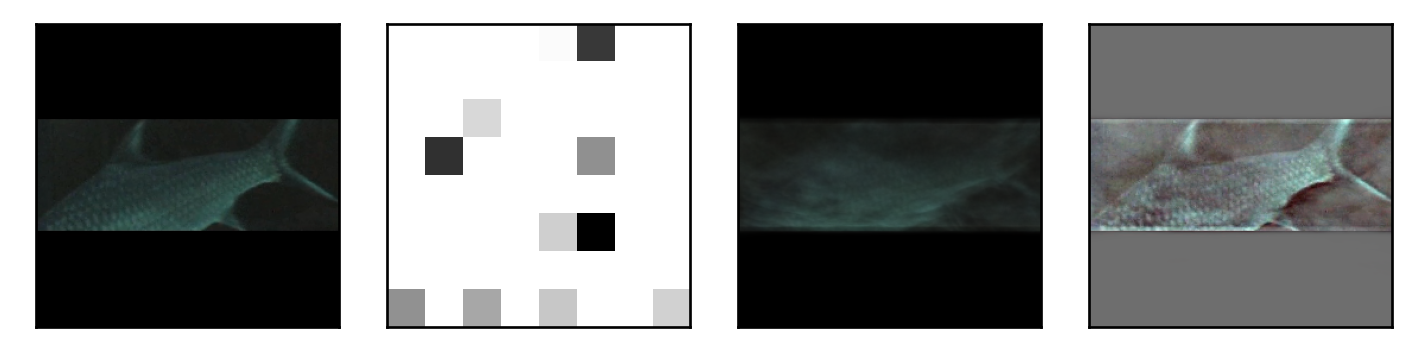

In [121]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(dpi=240, ncols=4)

ax0.imshow(my_faint_images[i].reshape(max_dim))
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

faint_encoded_imgs_min = faint_encoded_imgs[i].min()
faint_encoded_imgs_max = faint_encoded_imgs[i].max()
faint_encoded_imgs_val = (faint_encoded_imgs[i] - faint_encoded_imgs_min) / (faint_encoded_imgs_max - faint_encoded_imgs_min)

ax1.imshow(faint_encoded_imgs_val.reshape(encode_dimension, encode_dimension), cmap=plt.cm.binary)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.imshow(faint_decoded_imgs[i].reshape(max_dim))
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

faint_diff_image = my_faint_images[i] - faint_decoded_imgs[i]
faint_diff_image_min = faint_diff_image.min()
faint_diff_image_max = faint_diff_image.max()
faint_diff_image_val = (faint_diff_image - faint_diff_image_min) / (faint_diff_image_max - faint_diff_image_min)

ax3.imshow(faint_diff_image_val.reshape(max_dim), cmap=plt.cm.binary)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

In [122]:
benchmark(faint_diff_image)

0.17790308741983718